# Setup

In [ ]:
!pip install diffusers==0.18.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.4 MB/s eta 0:00:00


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Training Configuration

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    sequence_length = 256  # the generated image resolution
    train_data_paths = ['/content/p8_111.csv']
    filter_class = 1 # relax: 0, open: 1, and close: 2
    channel_shuffle = False
    emgs_cnt = 8 # must be 8 for 2D UNet

    train_standardize = True

    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    save_epochs = 50
    learning_rate = 4e-4

    noise_scheduler_timesteps = 500

    # these three should be deleted
    noise_type = "normal" # normal
    noise_mean = 0
    noise_std = 1 # if using huggingface pipeline, set it to 1

    gen_batch_size = 9 # gen_batch_size = nrows * ncols
    nrows = 3
    ncols = 3

    model_type = "2DUNet"

    load_model = False
    load_model_path = "./2Dunet-p8-111-close2-ep400"
    train = True
    save_model = True
    save_model_path = "./2Dunet-p8-111-standardized-open1-ep200"


config = TrainingConfig()

# Visualization Helper functions

From misc_utils

In [ ]:
import matplotlib.pyplot as plt

def plot_emg_chunks(data, nrows=1, ncols=1, vertical_location=None):
    """
    data: (b, t, 8), b = nrows * ncols
    """
    # missing the batch dimension
    if np.ndim(data) == 2:
        data = data[None, ...]
    b, t = data.shape[:2]
    fig, axs = plt.subplots(figsize=(15, 9), nrows=nrows, ncols=ncols, squeeze=False)

    idx = np.array(range(t)) / 100.0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown']

    for i in range(nrows):
        for j in range(ncols):
            for c in range(8):
                y = data[i*ncols+j, :, c]
                axs[i, j].plot(idx, y, label=f'emg{c}', alpha=0.7, color=colors[c])
                if vertical_location is not None:
                    axs[i, j].axvline(x=vertical_location / 100.0, c='b')
                if i*ncols+j == b - 1:
                    axs[i, j].legend()

    plt.xlabel('time (seconds)')
    plt.tight_layout()

    plt.show()

#ChatEMG Dataset

Statistics of p1_111:<br>
Mean of each emg: <br>[0.0451946  0.14492683 0.19912494 0.08450989 0.08813588 0.05372675
 0.04034895 0.07792921] <br>
Std of each emg: <br>
[0.02988127 0.06865422 0.11946873 0.07062819 0.07399311 0.08520439
 0.02091565 0.04998798]

From misc_utils.py

In [ ]:
# copied from misc_utils.py from emg_predictors
def keep_columns(df, tuple_of_columns):
    """
    Given a dataframe, and a tuple of column names, this function will search
    through the dataframe and keep only columns which contain a string from the
    list of the desired columns. All other columns are removed
    """
    if len(tuple_of_columns) >= 1:
        cols = df.columns[df.columns.to_series().str.contains('|'.join(tuple_of_columns))]
        return df[cols]
    return df

def clean_dataframe(df):
    X_df = keep_columns(df, [f'emg'])
    X = X_df.to_numpy()
    y_df = keep_columns(df, ['gt'])
    y = y_df.to_numpy().squeeze()
    return X, y

From ChatEMG Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
#import misc_utils as mu
import pandas as pd
import numpy as np

class ChatEMGDataset(Dataset):
    def __init__(self, csv_files, filter_class, block_size, normalize=False, standardize=False, shuffle_channel=False):
        assert not (normalize and standardize)  # cannot standardize and normalize at the same time
        self.csv_files = csv_files
        self.filter_class = filter_class
        self.block_size = block_size
        self.shuffle_channel = shuffle_channel
        self.normalize = normalize
        self.standardize = standardize

        #self.data_files_base_directory = \os.path.join(pathlib.Path(__file__).resolve().parent.parent.__str__(), 'collected_data')

        data_list = []
        label_list = []
        for f in self.csv_files:
            #data_path = os.path.join(self.data_files_base_directory, f)
            data_path = f
            df = pd.read_csv(data_path, index_col=0)
            #X, y = mu.clean_dataframe(df)
            X, y = clean_dataframe(df)
            if normalize:
                X = np.clip(X, a_min=0, a_max=999)
                X = X / 999
            data_list.append(X)
            label_list.append(y)

        self.filtered_data_list = data_list
        if self.filter_class is not None:
            self.filtered_data_list = []
            for d, l in zip(data_list, label_list):
                filtered_d = []
                for i in range(len(d)):
                    if l[i] == self.filter_class:
                        filtered_d.append(d[i])
                        if i+1 == len(d) or l[i+1] != self.filter_class:
                            self.filtered_data_list.append(np.array(filtered_d))
                            filtered_d = []

        # now I am removing chunks shorter than block size + 1, because we need to consider y as well
        self.filtered_data_list = [d for d in self.filtered_data_list if len(d) >= (self.block_size + 1)]
        # compute mean and std
        self.mean = np.mean(np.concatenate(self.filtered_data_list), axis=0)
        self.std = np.std(np.concatenate(self.filtered_data_list), axis=0)
        if self.standardize:
            self.filtered_data_list = [(d - self.mean) / self.std for d in self.filtered_data_list]
        # number of (x, y) pairs in each chunk
        self.filtered_data_lens = [len(d) - self.block_size for d in self.filtered_data_list]

    def overwrite_mean_std(self, mean, std):
        assert self.standardize
        # revert the standardization process
        self.filtered_data_list = [d * self.std + self.mean for d in self.filtered_data_list]
        self.mean = mean
        self.std = std
        # standardization using the new mean and std
        self.filtered_data_list = [(d - self.mean) / self.std for d in self.filtered_data_list]

    def __len__(self):
        return sum(self.filtered_data_lens)

    def __getitem__(self, item):
        assert item < self.__len__()

        s = 0
        for i, l in enumerate(self.filtered_data_lens):
            s_new = s + l
            if s <= item < s_new:
                x = self.filtered_data_list[i][item - s: item - s + self.block_size]
                # print(item - s, item - s + self.block_size)
                y = self.filtered_data_list[i][item - s + 1: item - s + self.block_size + 1]
                # print(item - s + 1, item - s + self.block_size + 1)
                # print(i)
                if self.shuffle_channel:
                    permutation = np.random.permutation(8)
                    x = x[:, permutation]
                    y = y[:, permutation]
                return x, y
            s = s_new

    def sample(self, num):
        # sample some samples without replacement
        idx = np.random.choice(range(self.__len__()), num, replace=False)
        X = []
        Y = []
        for i in idx:
            x, y = self.__getitem__(i)
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

In [ ]:
dataset = ChatEMGDataset(
    csv_files = config.train_data_paths,
    filter_class = config.filter_class,
    block_size = config.sequence_length,
    normalize = False,
    standardize = config.train_standardize,
    shuffle_channel = config.channel_shuffle
)
print("sum samples: ", len(dataset))

sum samples:  952


In [ ]:
print(dataset.mean)
print(dataset.std)

[305.46976744 121.43255814 215.76686047 159.42790698  89.42906977
 208.80581395 410.12965116 309.07674419]
[ 94.01225931  95.4521193   67.19553864  57.47996142  22.26815103
  70.67925069 129.29012824 102.02121265]


Support function: get_sample, will convert to our shape

In [ ]:
def get_sample(cnt):
  raw_sample = dataset.sample(cnt)
  # convert to np array
  np_sample = np.array(raw_sample) # (2, cnt, block_size, emg_cnt)
  # take only the X component
  x_sample = np_sample[0] # (cnt, block_size, emg_cnt)
  # permute the dimensions
  trans_sample = np.transpose(x_sample, axes=(0,2,1)) #(cnt, emg_cnt, block_size)
  # convert to torch
  sample_tensor = torch.tensor(trans_sample).to(torch.float32)
  return sample_tensor

In [ ]:
import torch

#train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config.train_batch_size, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
sample_seqs = np.array(dataset.sample(9))
sample_seqs = sample_seqs[0]
print(sample_seqs.shape)
plot_emg_chunks(sample_seqs, nrows=3, ncols=3)

support function to convert standardized data back to original value

In [ ]:
def convert(means, stds, seqs):
  print(seqs.shape) # (9, 256, 8)
  # Create an array to store the original scaled data
  original_data = np.zeros_like(seqs)

  # Reverse the standardization process for each channel
  for channel in range(8):
    original_data[:, :, channel] = seqs[:, :, channel] * stds[channel] + means[channel]
  return original_data

In [ ]:
converted_seqs = convert(dataset.mean, dataset.std, sample_seqs)
plot_emg_chunks(converted_seqs, nrows=3, ncols=3)

# Load an Existing UNet2D Model

In [ ]:
!unzip 2Dunet-p8-111-close2-ep200.zip

Archive:  2Dunet-p8-111-close2-ep200.zip
replace content/2Dunet-p8-111-close2-ep200/diffusion_pytorch_model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/2Dunet-p8-111-close2-ep200/diffusion_pytorch_model.bin  
  inflating: content/2Dunet-p8-111-close2-ep200/config.json  


In [ ]:
from diffusers import UNet2DModel
if config.load_model and config.model_type=="2DUNet":
  model = UNet2DModel.from_pretrained(config.load_model_path).to(device)

In [ ]:
model = UNet2DModel.from_pretrained('/content/content/2Dunet-p8-111-close2-ep200').to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Create a UNet2DModel

In [ ]:
from diffusers import UNet2DModel

# Create a model
if not config.load_model:
  model = UNet2DModel(
      sample_size=(config.emgs_cnt,config.sequence_length),  # the target image resolution
      in_channels=1,  # the number of input channels, 3 for RGB images
      out_channels=1,  # the number of output channels
      layers_per_block=2,  # how many ResNet layers to use per UNet block
      block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
      down_block_types=(
          "DownBlock2D",  # a regular ResNet downsampling block
          "DownBlock2D",
          "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
          "AttnDownBlock2D",
      ),
      up_block_types=(
          "AttnUpBlock2D",
          "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
          "UpBlock2D",
          "UpBlock2D",  # a regular ResNet upsampling block
      ),
  )
  model.to(device);

use pretrained checkpoints

check the input shape and output shape

In [ ]:
sample_seq = get_sample(1)
print(sample_seq.shape)
sample_for_plot = sample_seq.permute(0,2,1)
plot_emg_chunks(sample_for_plot)
sample_seq = sample_seq.to(device)

if config.model_type=="2DUNet":
  sample_seq = sample_seq.unsqueeze(1)
print("Input shape:", sample_seq.shape)

Expect format: (batch, channel, height, width).

In [ ]:
print("Output shape:", model(sample_seq, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 8, 256])


Check the number of parameters

In [ ]:
sum([p.numel() for p in model.parameters()])

18534017

# Create a Scheduler

Create a noise scheduler & plot its scheduling curve

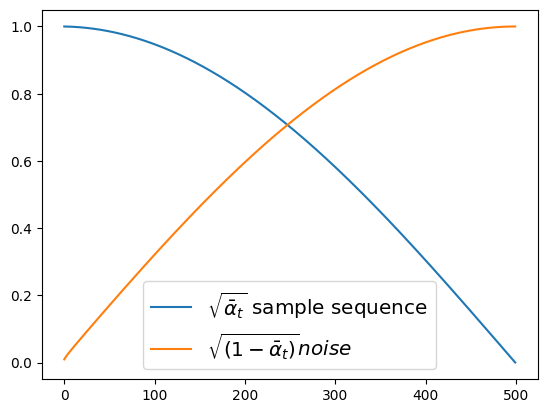

In [ ]:
from diffusers import DDPMScheduler

# Scheduler: can change parameters such as beta_start=0.001, beta_end=0.004, beta_schedule='squaredcos_cap_v2'
noise_scheduler = DDPMScheduler(num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule='squaredcos_cap_v2')

# plot
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$ sample sequence")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)} noise$")
plt.legend(fontsize="x-large");

# Create a Train Loop

from train.py

In [ ]:
def get_batch(split):
    if split == 'train':
        return next(iter(train_dataloader))
    elif split == 'val':
        return next(iter(test_dataloader))

my support function

In [ ]:
def diffuser_batch_preprocess(X, is2d=False):
  trans_X = np.transpose(X, axes=(0,2,1))
  tensor_X = torch.tensor(trans_X).to(torch.float32)
  if is2d:
    tensor_X = tensor_X.unsqueeze(1)
    # expected shape: (batch, channel, height, width),
    # here we are setting it to (batch, 1, height=8=emgChannels, width=sequence_length)
  return tensor_X

check generate seqs

In [ ]:
from diffusers import DDPMPipeline

def deterministic_generate_sequences(this_model):
  deterministic_generator = torch.Generator()
  deterministic_generator.manual_seed(42)
  emgseq_pipe = DDPMPipeline(unet=this_model, scheduler=noise_scheduler)
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array,generator=deterministic_generator)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape) #(9, 8, 256)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1)) #(9, 256, 8)
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  print("Standardized model output: ")
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  print("Converted model output: ")
  converted = convert(dataset.mean, dataset.std, gen_seqs)
  plot_emg_chunks(converted, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

Total epochs:  200
Epoch:  0


<ipython-input-20-050d5c5ac8e0>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_X = torch.tensor(trans_X).to(torch.float32)


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:5, loss: 0.022623504232615232
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:10, loss: 0.03197363823031386
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:15, loss: 0.01930865670243899
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:20, loss: 0.025209131774803002
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:25, loss: 0.028686179344852767
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:30, loss: 0.01830349899828434
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:35, loss: 0.01807983419081817
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:40, loss: 0.01843455816463878
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:45, loss: 0.018378057641287644
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:50, loss: 0.01821866784399996
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.85048366 0.8190732  0.83173764 ... 0.2518674  0.23587845 0.22455873]
 [0.64025575 0.66716665 0.66794837 ... 0.70900536 0.7144722  0.81232053]
 [0.50262    0.49755472 0.45640573 ... 0.27483556 0.2666167  0.26882213]
 ...
 [0.19554088 0.19766901 0.2397358  ... 0.10636954 0.12142992 0.12200919]
 [0.8190201  0.80753493 0.80854166 ... 0.78758055 0.80296254 0.80572724]
 [0.4948467  0.5047072  0.49508104 ... 0.51345384 0.509286   0.49804187]]
std:  [[0.1819757  0.18397361 0.17241868 ... 0.13652213 0.15109867 0.16932075]
 [0.18710314 0.2070077  0.20271105 ... 0.21076673 0.21144234 0.21129097]
 [0.1244939  0.1227323  0.10975533 ... 0.11461771 0.12177645 0.12079094]
 ...
 [0.16485651 0.16381937 0.1801787  ... 0.1050076  0.10281509 0.10523046]
 [0.19470468 0.18584004 0.184304   ... 0.21655387 0.19769701 0.2051683 ]
 [0.13926731 0.12616776 0.12345594 ... 0.17459197 0.17839675 0.19864501]]
Standardized model output: 


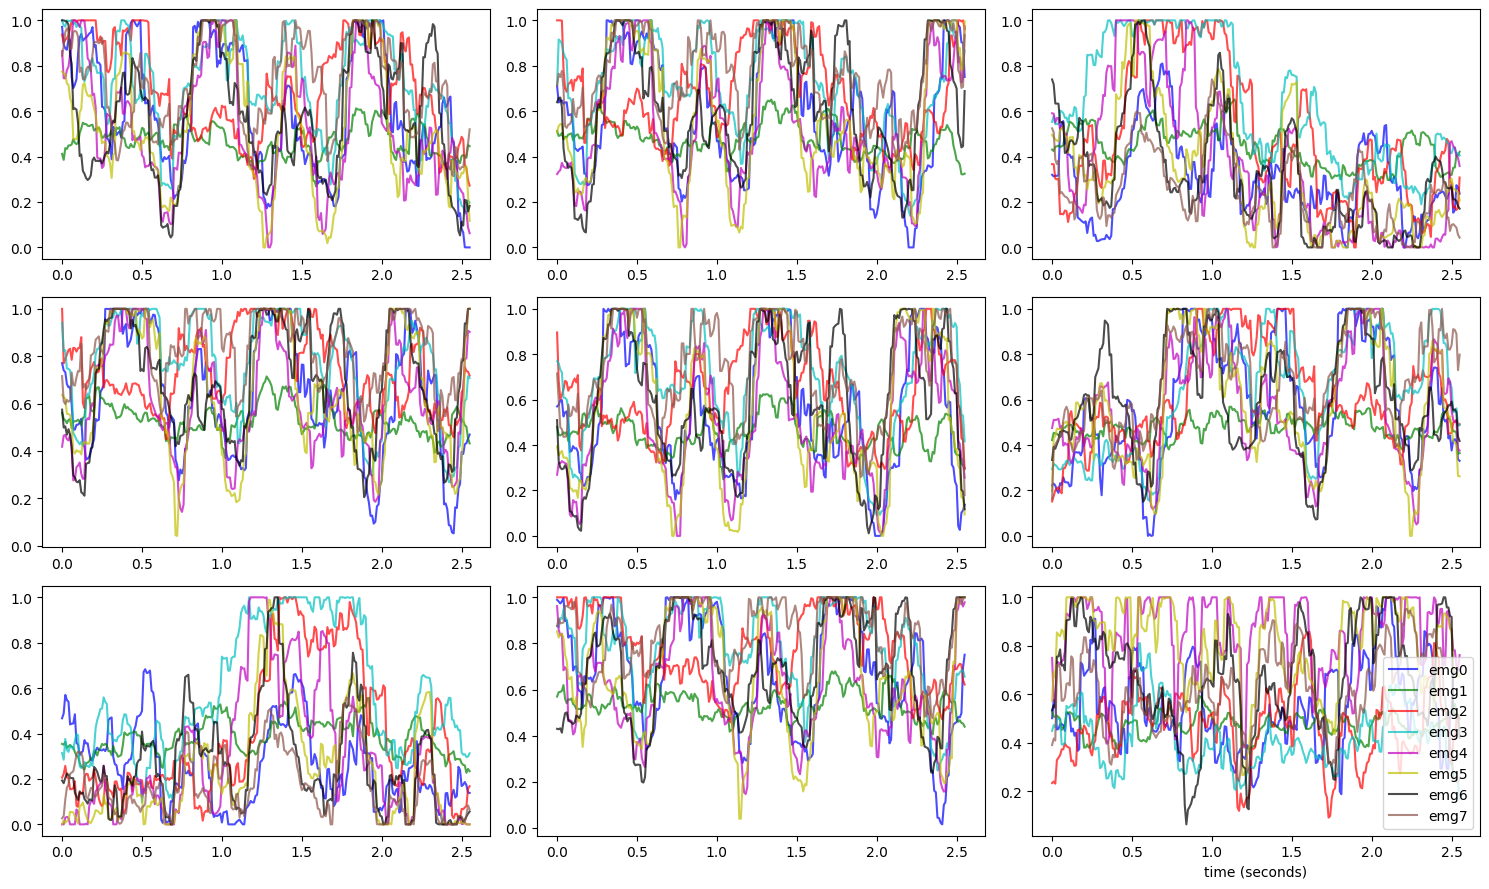

Converted model output: 
(9, 256, 8)


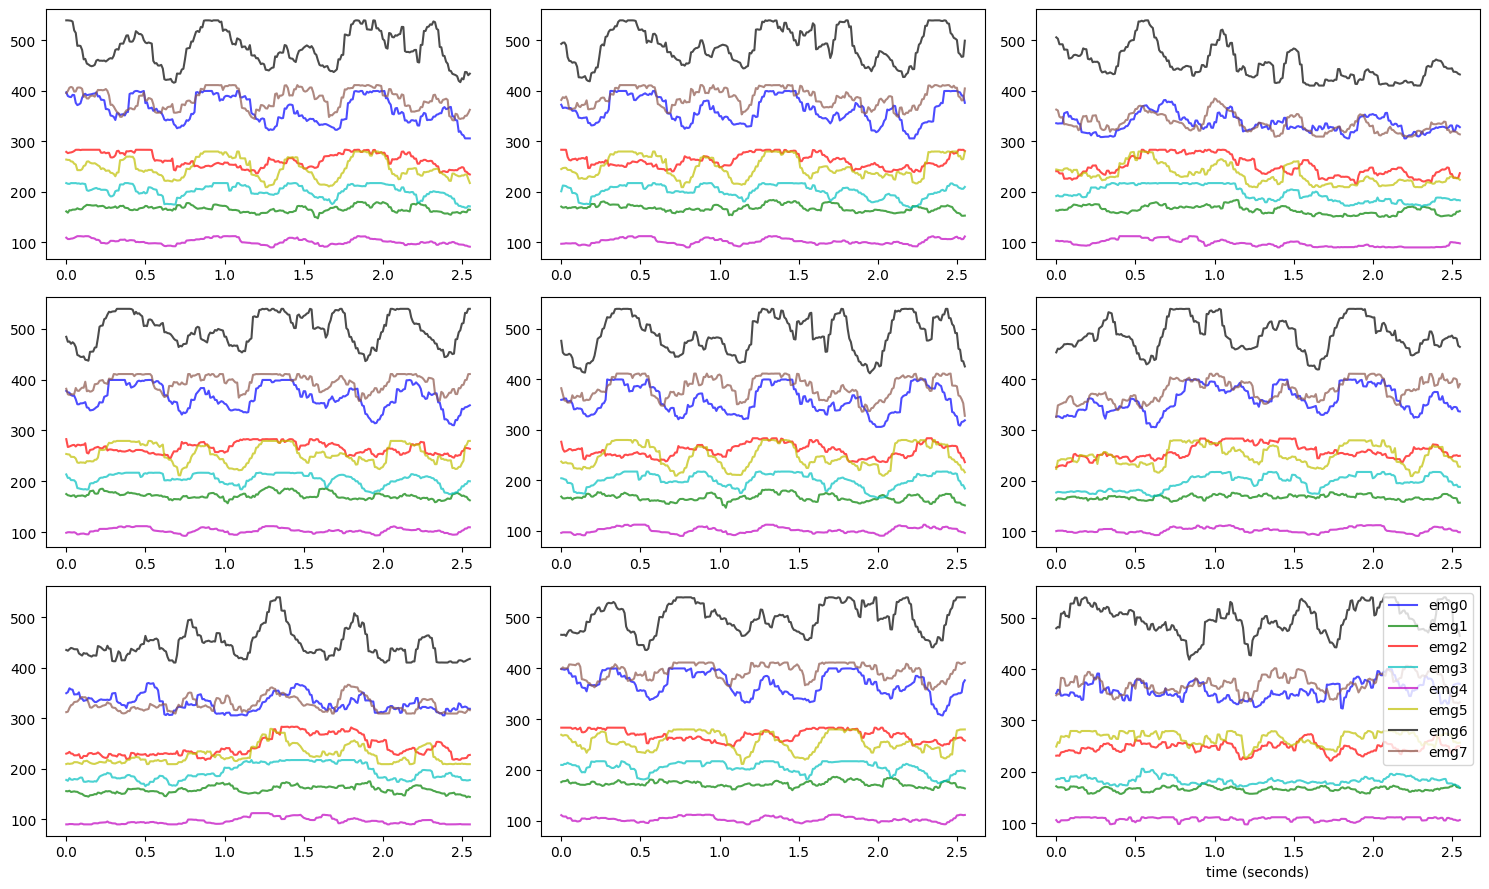

Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:55, loss: 0.01988894937094301
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:60, loss: 0.018538994357610743
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:65, loss: 0.01588670222554356
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:70, loss: 0.010423000253892194
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:75, loss: 0.01347560806510349
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:80, loss: 0.020584263078247508
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:85, loss: 0.0235278357208396
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:90, loss: 0.014869415845411519
Epoch:  90
Epoch:  91
Epoch:  92
Epoch:  93
Epoch:  94
Epoch:95, loss: 0.01451347095426172
Epoch:  95
Epoch:  96
Epoch:  97
Epoch:  98
Epoch:  99
Epoch:100, loss: 0.011406561049322287
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.4269475  0.41860402 0.39548558 ... 0.47806096 0.47916925 0.47799903]
 [0.19501528 0.22019535 0.21767798 ... 0.49532485 0.483635   0.48746395]
 [0.1996214  0.14548214 0.14817695 ... 0.11426944 0.11851579 0.13768199]
 ...
 [0.17465971 0.17031844 0.16545951 ... 0.0749383  0.09159261 0.09141906]
 [0.45272788 0.48560125 0.48667973 ... 0.72849274 0.70386153 0.78743213]
 [0.07440217 0.07457206 0.07010463 ... 0.35405195 0.35252696 0.34388405]]
std:  [[0.19145083 0.19005914 0.15179902 ... 0.13852486 0.13591407 0.14038178]
 [0.13378829 0.1780775  0.1749523  ... 0.2569544  0.2629754  0.27018315]
 [0.07959224 0.08962459 0.08680253 ... 0.11468302 0.11040851 0.11525343]
 ...
 [0.15687212 0.15563472 0.14706141 ... 0.08825913 0.08027737 0.08236428]
 [0.17556123 0.13036992 0.12443006 ... 0.25931147 0.2210811  0.25173745]
 [0.0978609  0.09191757 0.09438195 ... 0.18856987 0.19566534 0.20089531]]
Standardized model output: 


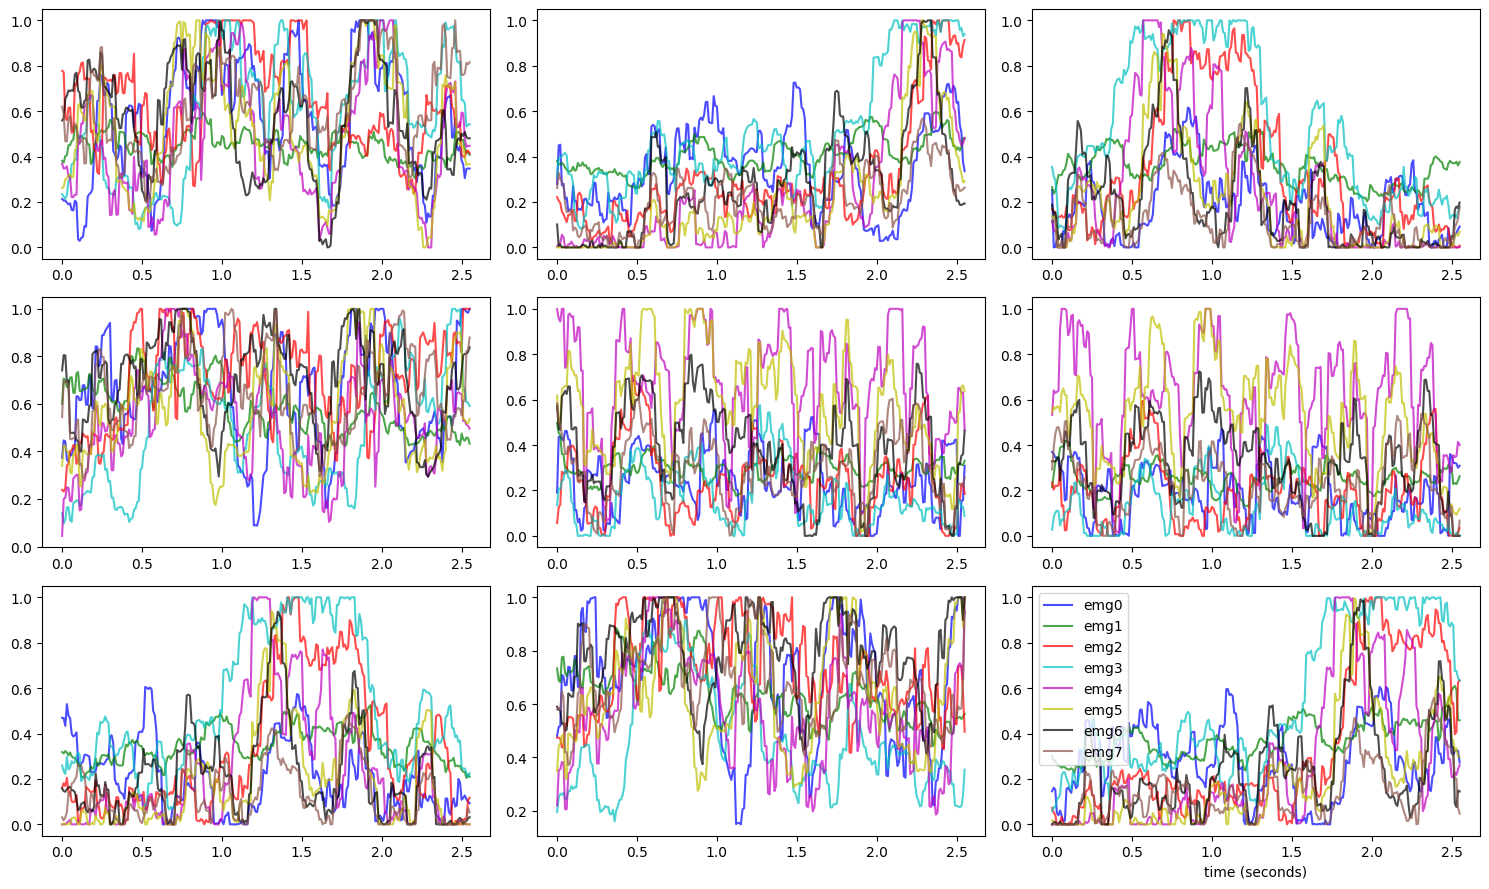

Converted model output: 
(9, 256, 8)


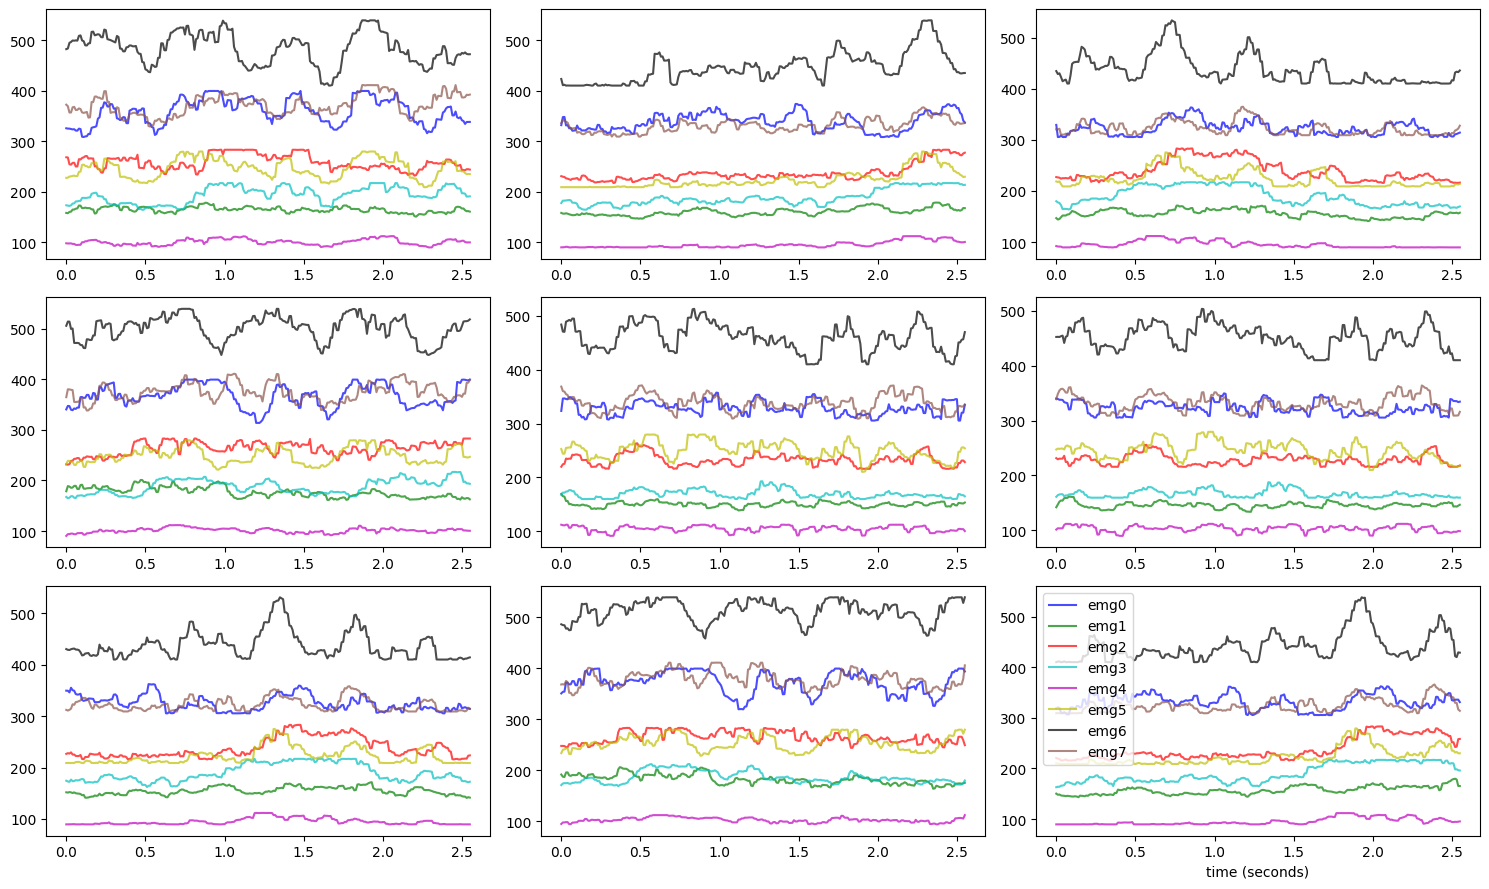

Epoch:  100
Epoch:  101
Epoch:  102
Epoch:  103
Epoch:  104
Epoch:105, loss: 0.019235090321550765
Epoch:  105
Epoch:  106
Epoch:  107
Epoch:  108
Epoch:  109
Epoch:110, loss: 0.0166515240057682
Epoch:  110
Epoch:  111
Epoch:  112
Epoch:  113
Epoch:  114
Epoch:115, loss: 0.013911748367051283
Epoch:  115
Epoch:  116
Epoch:  117
Epoch:  118
Epoch:  119
Epoch:120, loss: 0.020549907900082567
Epoch:  120
Epoch:  121
Epoch:  122
Epoch:  123
Epoch:  124
Epoch:125, loss: 0.014759838006769617
Epoch:  125
Epoch:  126
Epoch:  127
Epoch:  128
Epoch:  129
Epoch:130, loss: 0.012532568901466827
Epoch:  130
Epoch:  131
Epoch:  132
Epoch:  133
Epoch:  134
Epoch:135, loss: 0.014668920131710669
Epoch:  135
Epoch:  136
Epoch:  137
Epoch:  138
Epoch:  139
Epoch:140, loss: 0.011607202872013053
Epoch:  140
Epoch:  141
Epoch:  142
Epoch:  143
Epoch:  144
Epoch:145, loss: 0.01292407432726274
Epoch:  145
Epoch:  146
Epoch:  147
Epoch:  148
Epoch:  149
Epoch:150, loss: 0.018040900281630457
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.6713185  0.6999036  0.7032313  ... 0.28749222 0.30076352 0.30475026]
 [0.3197545  0.31036645 0.31113404 ... 0.7059158  0.7128307  0.6722572 ]
 [0.18266213 0.20652843 0.20780925 ... 0.664839   0.66195834 0.6514608 ]
 ...
 [0.17652036 0.17060685 0.16418368 ... 0.0735653  0.07881983 0.08539215]
 [0.7389622  0.7357751  0.72258264 ... 0.7514352  0.7877255  0.7918464 ]
 [0.12924102 0.18809475 0.18479119 ... 0.39289087 0.35540414 0.35567516]]
std:  [[0.11218747 0.20640852 0.20503187 ... 0.17476436 0.17999808 0.18151422]
 [0.20676583 0.1932122  0.19116196 ... 0.23505157 0.23783612 0.260731  ]
 [0.07614165 0.07436959 0.08404154 ... 0.22576231 0.22664544 0.22668667]
 ...
 [0.14856695 0.15844557 0.14795417 ... 0.08583578 0.07193542 0.07752327]
 [0.12413103 0.11920539 0.11216691 ... 0.12222737 0.18551658 0.18819457]
 [0.10473816 0.13219307 0.13114487 ... 0.28648168 0.27017835 0.27681714]]
Standardized model output: 


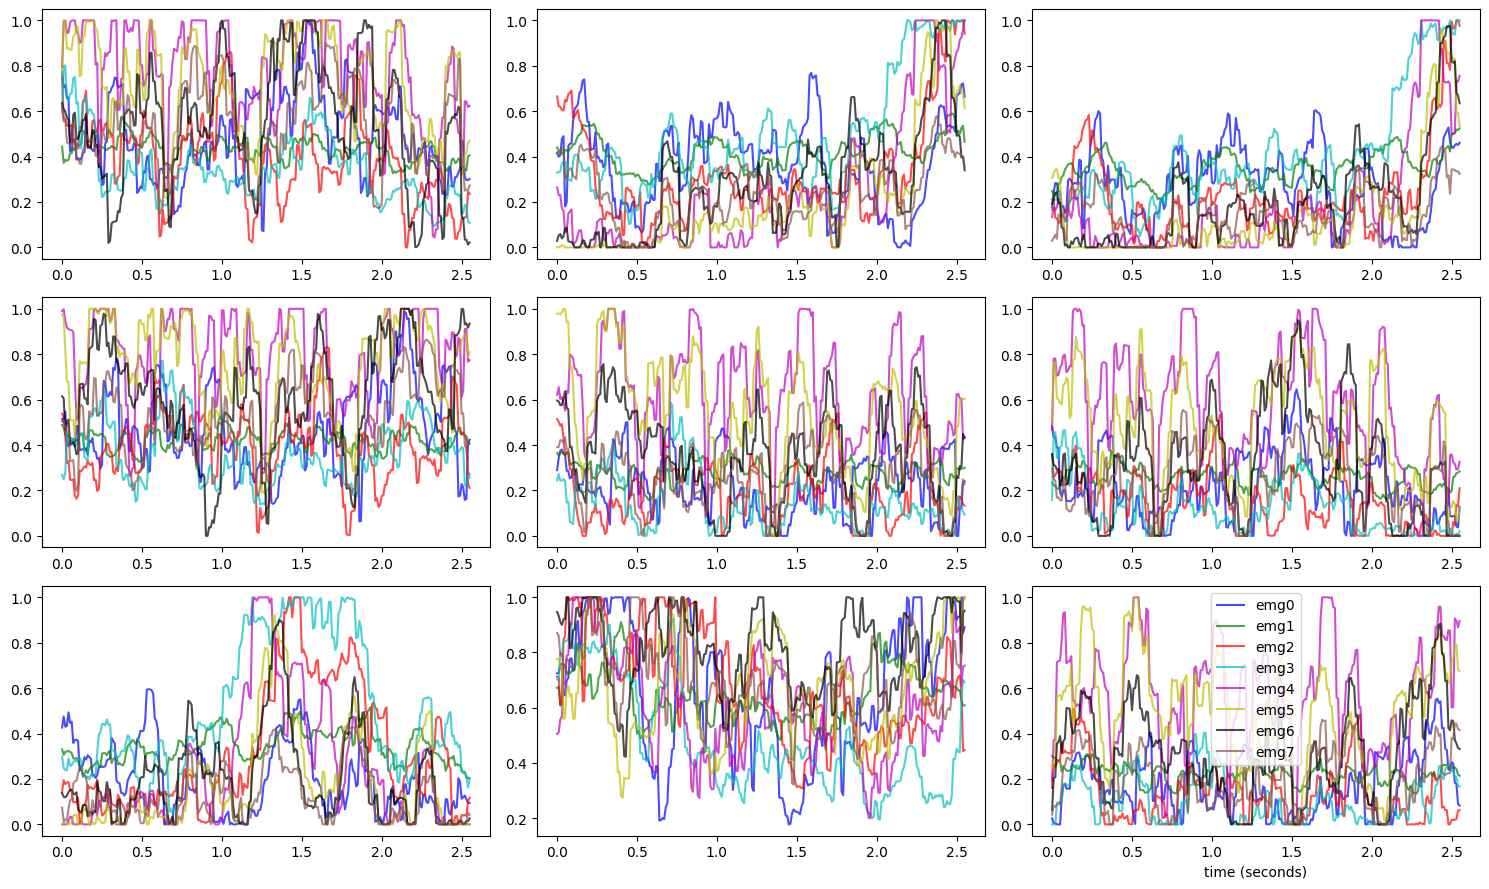

Converted model output: 
(9, 256, 8)


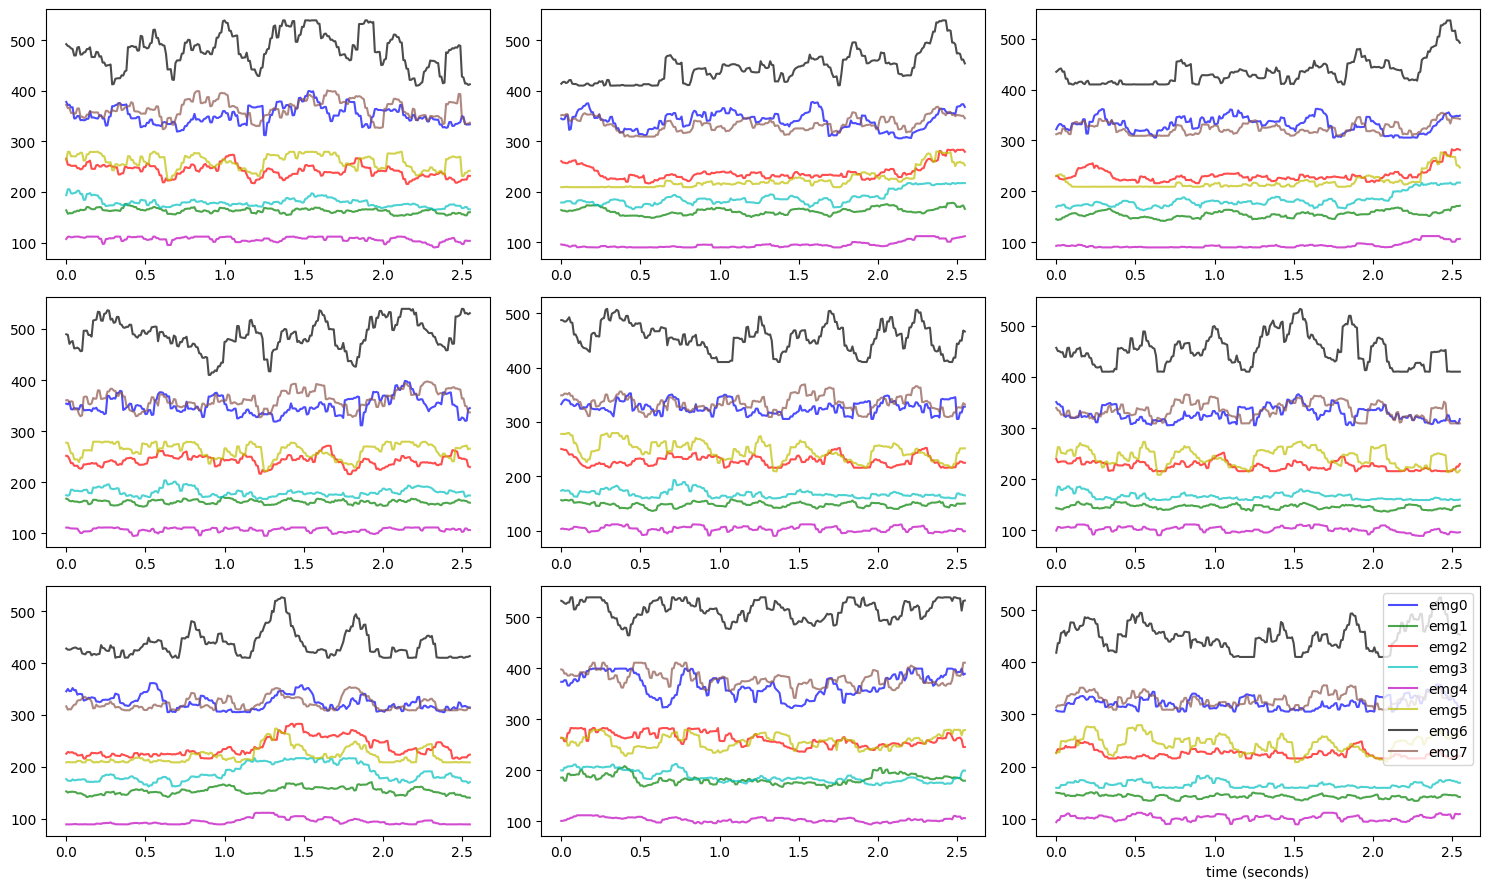

Epoch:  150
Epoch:  151
Epoch:  152
Epoch:  153
Epoch:  154
Epoch:155, loss: 0.014269357143590847
Epoch:  155
Epoch:  156
Epoch:  157
Epoch:  158
Epoch:  159
Epoch:160, loss: 0.010576491399357716
Epoch:  160
Epoch:  161
Epoch:  162
Epoch:  163
Epoch:  164
Epoch:165, loss: 0.014406675829862554
Epoch:  165
Epoch:  166
Epoch:  167
Epoch:  168
Epoch:  169
Epoch:170, loss: 0.01681758719496429
Epoch:  170
Epoch:  171
Epoch:  172
Epoch:  173
Epoch:  174
Epoch:175, loss: 0.020548630459234118
Epoch:  175
Epoch:  176
Epoch:  177
Epoch:  178
Epoch:  179
Epoch:180, loss: 0.017735691632454594
Epoch:  180
Epoch:  181
Epoch:  182
Epoch:  183
Epoch:  184
Epoch:185, loss: 0.01156274260332187
Epoch:  185
Epoch:  186
Epoch:  187
Epoch:  188
Epoch:  189
Epoch:190, loss: 0.013045550727595886
Epoch:  190
Epoch:  191
Epoch:  192
Epoch:  193
Epoch:  194
Epoch:195, loss: 0.014538339463373025
Epoch:  195
Epoch:  196
Epoch:  197
Epoch:  198
Epoch:  199
Epoch:200, loss: 0.015479058376513422
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.45932326 0.45385802 0.45934945 ... 0.13319553 0.13558255 0.15246344]
 [0.05431769 0.07822508 0.07409383 ... 0.4021586  0.41493607 0.44329134]
 [0.20096675 0.16053082 0.16083881 ... 0.10156236 0.10442042 0.1484094 ]
 ...
 [0.21730174 0.22280884 0.2198054  ... 0.25950238 0.25461903 0.2093468 ]
 [0.29953963 0.29760417 0.24406107 ... 0.2683814  0.2621089  0.2423514 ]
 [0.18138076 0.22574568 0.21867284 ... 0.12098003 0.12248369 0.11202416]]
std:  [[0.07685152 0.08267534 0.08128735 ... 0.10323582 0.1035807  0.14773247]
 [0.05257606 0.0527892  0.04930592 ... 0.20902738 0.21969809 0.28869697]
 [0.18818821 0.12758987 0.13016929 ... 0.08521348 0.08749866 0.10450988]
 ...
 [0.14951776 0.14181921 0.12432289 ... 0.2071247  0.20751227 0.13600005]
 [0.180886   0.17539804 0.13784117 ... 0.17334406 0.17361398 0.19217482]
 [0.15939654 0.14872824 0.14726582 ... 0.11527823 0.11103065 0.10515262]]
Standardized model output: 


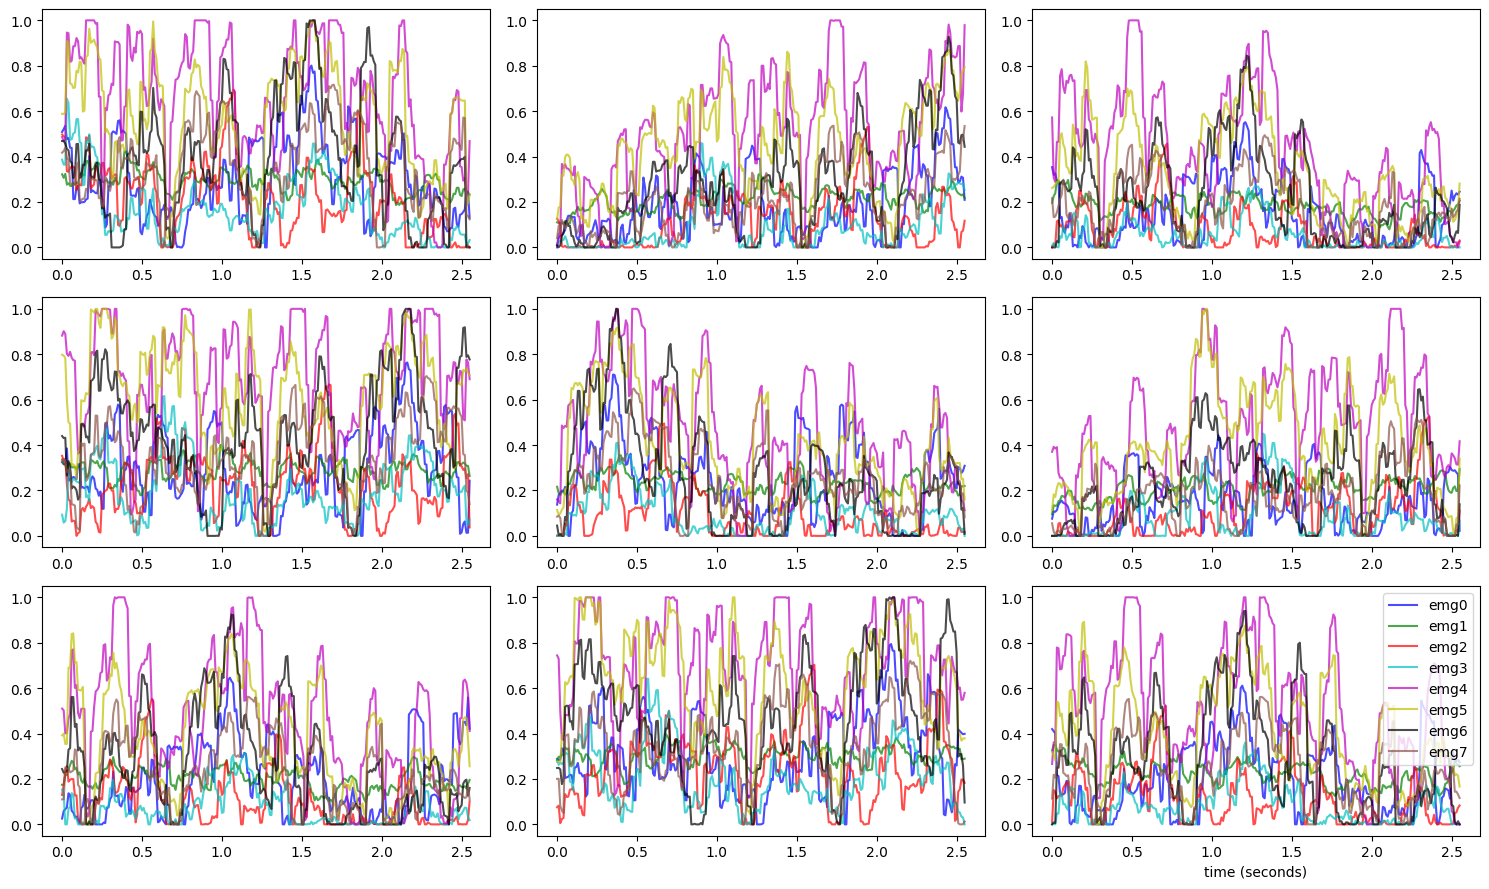

Converted model output: 
(9, 256, 8)


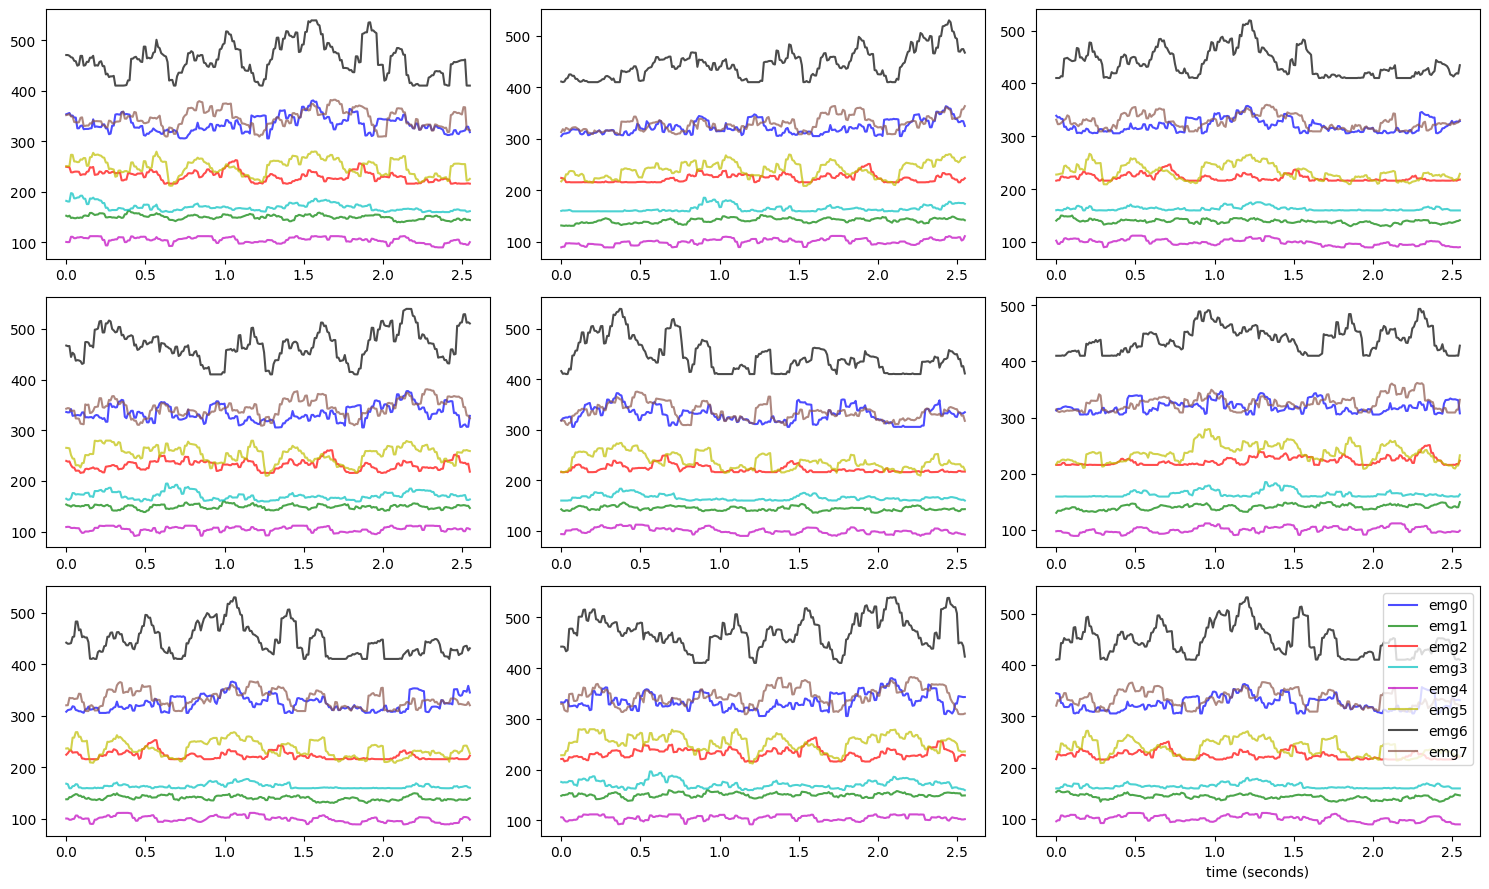

In [ ]:
import torch.nn.functional as F

if config.train:
  # Set the noise scheduler
  noise_scheduler = DDPMScheduler(
      num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule="squaredcos_cap_v2"
  )

  # Training loop
  optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

  losses = []

  print("Total epochs: ",  config.num_epochs)
  for epoch in range(config.num_epochs):
      print("Epoch: ", epoch)
      for step, batch in enumerate(train_dataloader):
        batch_x, batch_y = get_batch('train')
        batch = diffuser_batch_preprocess(batch_x, is2d=True)
        clean_seqs = batch.to(device)
          #print("batch shape: ", batch.shape)

          # Sample noise to add to the images
        noise = torch.randn(clean_seqs.shape).to(device)

        bs = clean_seqs.shape[0] #batch size

          # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

          # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_seqs = noise_scheduler.add_noise(clean_seqs, noise, timesteps)

          # Get the model prediction
        noise_pred = model(noisy_seqs, timesteps, return_dict=False)[0]

          # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

          # Update the model parameters with the optimizer
          # why UNet side no gradient
        optimizer.step()
        optimizer.zero_grad()

      if (epoch + 1) % 5 == 0:
          loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
          print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
      # saving
      if (epoch + 1) % config.save_epochs == 0: #config.save_epochs
        print("Saving...")
        save_path = "./2DUnet-p8-train-ep"+str(epoch+1)
        model.save_pretrained(save_path)
        output = deterministic_generate_sequences(model)

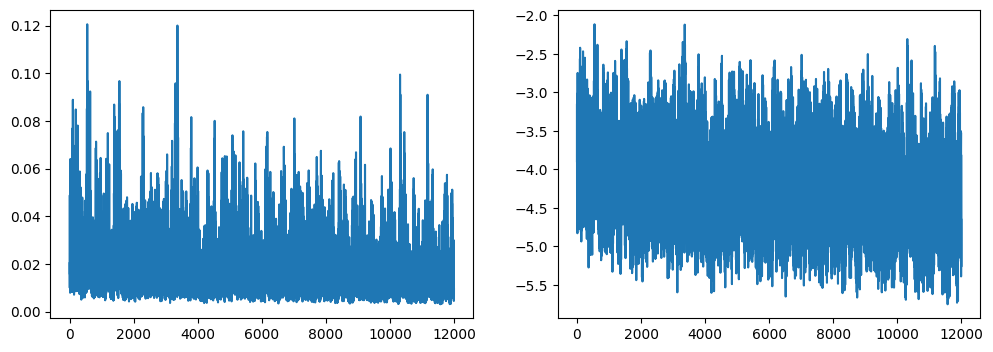

In [ ]:
if config.train:
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(losses)
  axs[1].plot(np.log(losses))
  plt.show()

# Save model

In [ ]:
if config.save_model:
  model.save_pretrained(config.save_model_path)

# Generate Sequence

In [ ]:
from diffusers import DDPMPipeline

emgseq_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
def generate_sequences():
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("final shape: ", gen_seqs.shape)
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  print("Model output:")
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  print("Reverse-standardized Model output:")
  converted = convert(dataset.mean, dataset.std, gen_seqs)
  plot_emg_chunks(converted, nrows=config.nrows, ncols=config.ncols)
  return gen_seqs

In [ ]:
output = generate_sequences() #(9, 256, 8)

# transform by first finding the most similar existing sequence, then reverse normalize with the existing sequence's mean and std

# For Comparison

In [ ]:
from diffusers import DDPMPipeline


In [ ]:
output = deterministic_generate_sequences(model)


#Find the closest sample in Dataset

For standardized

In [ ]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf

def find_similar_standardized(gen_seqs, dataset):
  print("model_output shape: ", gen_seqs.shape) # (9, 8, 256, 1)
  gen_seqs = gen_seqs.squeeze() # (9, 8, 256)
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("final shape: ", gen_seqs.shape) # (9, 256, 8)

  res = []
  for i in range(gen_seqs.shape[0]):
    model_output = gen_seqs[i]
    print("model output:")
    plot_emg_chunks(model_output, nrows=1, ncols=1)
    loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
    best_loss = 100000
    best_exist = None
    best_id = None
    cnt = 0
    for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
      exist_seq = exist_seq.squeeze()
      #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
      mse = mean_squared_error(model_output, exist_seq)
      #print("mse: ", mse)
      if mse < best_loss:
        best_loss = mse
        best_exist = exist_seq
        best_id = id
      cnt += 1
    print("cnt: ", cnt)
    plot_emg_chunks(best_exist, nrows=1, ncols=1)
    res.append(best_exist)
  res = tf.stack(res)
  return res

In [ ]:
best_exists = find_similar_standardized(output, dataset)

In [ ]:
print("Best Exists:")
plot_emg_chunks(best_exists, nrows=config.nrows, ncols=config.ncols)
print("Reverse-standardized Best Exists:")
converted = convert(dataset.mean, dataset.std, best_exists)
plot_emg_chunks(converted, nrows=config.nrows, ncols=config.ncols)

Given a model output, find the existing data in ChatEMGDataset that has similar shape. This is intend to check if the model output is just duplicate of existing data

In [ ]:
from sklearn.metrics import mean_squared_error

def find_similar(model_output, dataset):
  print("model_output shape: ", model_output.shape) #(256,8) after squeeze and transpose
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_id = None
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    mse = mean_squared_error(model_output, exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_id = id
  return best_loss, best_exist, best_id

In [ ]:
best_loss, best_existing_seq, best_id = find_similar(output[0], dataset)
print("best loss: ", best_loss)
print("best id: ", best_id)
print("best exist seq: ")
plot_emg_chunks(best_existing_seq, nrows=1, ncols=1)

In [ ]:
def find_similar_2(model_output, dataset):
  print("model_output shape: ", model_output.shape) #(256,8) after squeeze and transpose
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_id = None
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    model_output = model_output - 0.5
    model_output = model_output*2
    model_output[model_output < 0] = 0
    model_output[model_output > 1] = 1
    mse = mean_squared_error(model_output, exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_id = id
  return best_loss, best_exist, best_id

In [ ]:
def find_similar_3(model_output, dataset):
  print("model_output shape: ", model_output.shape) #(256,8) after squeeze and transpose
  loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)
  best_loss = 100000
  best_exist = None
  best_normalized = None
  best_id = None
  model_output_mean = np.mean(model_output, axis = 0)
  model_output_std = np.std(model_output, axis = 0)
  model_output = (model_output - model_output_mean) / model_output_std
  print("Normalized Model Output:")
  plot_emg_chunks(model_output, ncols=1, nrows=1)
  for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
    exist_seq = exist_seq.squeeze()
    exist_seq = np.array(exist_seq)
    #print("exist_seq shape: ", np.array(exist_seq).shape) #(256,8)
    # Calculate mean and standard deviation along each channel
    ex_mean = np.mean(exist_seq, axis=0)
    ex_std = np.std(exist_seq, axis=0)
    # Normalize each channel
    normalized_exist_seq = (exist_seq - ex_mean) / ex_std
    mse = mean_squared_error(model_output, normalized_exist_seq)
    #print("mse: ", mse)
    if mse < best_loss:
      best_loss = mse
      best_exist = exist_seq
      best_normalized = normalized_exist_seq
      best_id = id
  return best_loss, best_exist, best_normalized, best_id

In [ ]:
images = deterministic_generate_sequences(model)

In [ ]:
model_output = images[1]

In [ ]:
model_output = model_output.squeeze()
print(model_output.shape) #(8,256)

model_output = np.transpose(model_output, axes=(1,0))
print(model_output.shape) #(256,8)


(8, 256)
(256, 8)


In [ ]:
plot_emg_chunks(model_output, nrows=1, ncols=1)

In [ ]:
best_loss, best_existing_seq, best_normalized_seq, best_id = find_similar_3(model_output, dataset)
print("best loss: ", best_loss)
print("best id: ", best_id)
print("best normalized: ")
plot_emg_chunks(best_normalized_seq, nrows=1, ncols=1)
print("best exist seq: ")
plot_emg_chunks(best_existing_seq, nrows=1, ncols=1)


In [ ]:
loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=0, batch_size=1)

for id, (exist_seq, y) in enumerate(loader): # exist_seq is of shape (1, 256, 8)
  exist_seq = exist_seq.squeeze()
  if id<10:
    plot_emg_chunks(exist_seq, nrows=1, ncols=1)


In [ ]:
!zip -r '/content/2Dunet-p8-111-close2-ep200.zip' '/content/2Dunet-p8-111-close2-ep200'

  adding: content/2Dunet-p8-111-close2-ep200/ (stored 0%)
  adding: content/2Dunet-p8-111-close2-ep200/diffusion_pytorch_model.bin (deflated 8%)
  adding: content/2Dunet-p8-111-close2-ep200/config.json (deflated 58%)


In [ ]:
from google.colab import files
files.download('/content/2Dunet-p8-111-close2-ep200.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>